In [1]:
import cv2
import scipy
import skimage
import time

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
import SimpleITK as sitk

from scipy import sparse

from numba import vectorize, guvectorize, float32, int32, jit, cuda 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import math
from scipy import signal
from scipy.stats import entropy
from sklearn.cluster import KMeans # USAR EL DE RAPIDS

from typing import Optional

from utils import pixel_graph, gker, region_extractor

In [2]:
manufacturer = 'Cirrus'
itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-{manufacturer}/TRAIN001/oct.mhd')
ref_itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-{manufacturer}/TRAIN001/reference.mhd')

oct_scan = sitk.GetArrayFromImage(itkimage)
ref_oct_scan = sitk.GetArrayFromImage(ref_itkimage)

# plt.figure(figsize=(25,10))
# for i in range(5):
#     plt.subplot(1,5,i+1)
#     im1 = oct_scan[10*i,:,:]
#     im2 = ref_oct_scan[10*i,:,:]
#     im1, im2 = region_extractor(im1, im2, manufacturer)
#     plt.imshow(im1, cmap='gray')
#     plt.imshow(im2, alpha=0.2)
#     plt.axis('off')
# plt.figure(figsize=(25,10))
# for i in range(5):
#     plt.subplot(1,5,i+1)
#     i = i+5
#     im1 = oct_scan[10*i,:,:]
#     im2 = ref_oct_scan[10*i,:,:]
#     im1, im2 = region_extractor(im1, im2, manufacturer)
#     plt.imshow(im1, cmap='gray')
#     plt.imshow(im2, alpha=0.2)
#     plt.axis('off')
# plt.show()

In [3]:
def ns_mapper_using_complements(g: np.ndarray, max_iterations: int = 10):
    """
    Obtain the T and I matrices of the image g (one slice of the oct_scan)
    """
    # Step 2
    g_comp = 255 - g
    T = np.zeros(g_comp.shape)
    g_comp_min = np.min(g_comp)
    g_comp_max = np.max(g_comp)
    T = 1 - (g_comp - g_comp_min)/(g_comp_max - g_comp_min)
    
    # Step 3
    kernel = gker((3,9),1)
    
    # Steps 4,5, 6
    for it in range(max_iterations):
        I = np.zeros((T.shape))
        Ind = np.zeros((T.shape))
        FI = np.zeros((10, T.shape[0], T.shape[1]))
        for j in range(0,10):                                             # Step 5
            rotated_kernel = scipy.ndimage.rotate(kernel, 18*j, reshape=True)   # Step 4
            FI[j,:,:] = cv2.filter2D(T, -1, rotated_kernel)
        T_FI_abs_dif = np.abs(np.repeat(np.expand_dims(T,0),10,0) - FI)
        I = np.min(T_FI_abs_dif, axis=0)                                  # Step 6
        Ind = np.argmax(T_FI_abs_dif, axis=0)

        # Step 7 and 8
        idx = Ind[I >= 0.7]
        T[I >= 0.7] = FI[idx,I >= 0.7]
        
        # Step 9
        entropy = 0 if it==0 else entropy
        entropy_dif = np.abs(scipy.stats.entropy(I.flatten()) - entropy)
        if entropy_dif < 0.001:
            return T, I
        else:
            entropy = scipy.stats.entropy(I.flatten())
    print('Retourned by iterations')
    return T, I

In [4]:
def rashno_ns_mapper(g: np.ndarray, max_iterations: int = 10):
    """
    Obtain the T and I matrices of the image g (one slice of the oct_scan)
    """
    # Step 2
    g_comp = 255 - g
    T = np.zeros(g_comp.shape)
    g_comp_min = np.min(g_comp)
    g_comp_max = np.max(g_comp)
    T = 1 - (g_comp - g_comp_min)/(g_comp_max - g_comp_min)
    
    # Step 3
    kernel = gker((3,9),1)
    
    # Steps 4,5, 6
    for it in range(max_iterations):
        I = np.zeros((T.shape))
        Ind = np.zeros((T.shape))
        FI = np.zeros((10, T.shape[0], T.shape[1]))
        for j in range(0,10):                                             # Step 5
            rotated_kernel = scipy.ndimage.rotate(kernel, 18*j, reshape=True)   # Step 4
            FI[j,:,:] = cv2.filter2D(T, -1, rotated_kernel)
        T_FI_abs_dif = np.abs(np.repeat(np.expand_dims(T,0),10,0) - FI)
        I = np.min(T_FI_abs_dif, axis=0)                                  # Step 6
        Ind = np.argmax(T_FI_abs_dif, axis=0)

        # Step 7 and 8
        idx = Ind[I >= 0.7]
        T[I >= 0.7] = FI[idx,I >= 0.7]
        
        # Step 9
        entropy = 0 if it==0 else entropy
        entropy_dif = np.abs(scipy.stats.entropy(I.flatten()) - entropy)
        if entropy_dif < 0.001:
            return T, I
        else:
            entropy = scipy.stats.entropy(I.flatten())
    print('Retourned by iterations')
    return T, I

In [5]:
def mean_filter(img):
    w = 5
    wVal = 1/w
    conColMatrix = np.zeros(shape=(w,1))
    conColMatrix = np.add(conColMatrix, wVal)
    conRowMatrix = np.zeros(shape=(1,w))
    conRowMatrix  = np.add(conRowMatrix, wVal)
    a = signal.convolve2d(img, conColMatrix, boundary='symm', mode='same')
    return signal.convolve2d(a, conRowMatrix, boundary='symm', mode='same')

@jit(nopython=True)
def normalizer(item, minVal, maxVal):
    return (item - minVal) / (maxVal - minVal)

@jit(nopython=True)
def EnI_Pixel(item):
    return item * math.log2(item)

@jit(nopython=True)
def Alpha_I_Pixel(item,minVal, maxVal):
    return (item * minVal) / (maxVal - minVal)

# @jit(nopython=True)
# def Beta_I_Pixel(item,minVal, maxVal):
#     return (item * minVal) / (maxVal - minVal)

def Neutrsophic_Image(item):
    lmv = mean_filter(item)
    lmv_min = np.min(lmv)
    lmv_max = np.max(lmv)
    normalizer_func = np.vectorize(normalizer)
    T = normalizer_func(lmv, lmv_min, lmv_max)
    delta = np.absolute(np.array(item) - np.array(lmv))
    delta_min = np.min(delta)
    delta_max = np.max(delta)
    I = normalizer_func(delta, delta_min, delta_max)
    F = 1 - T
    pns = np.zeros((T.shape[0], T.shape[1], 3))
    pns[:,:,0] = T
    pns[:,:,1] = I
    pns[:,:,2] = F
    return pns

def old_school_ns(img, enI, alpha, beta):
    T = img[:,:,0]
    I = img[:,:,1]
    
    T_shape = T.shape

    # T_alpha mean
    meanT = mean_filter(T)
    alphaT = np.ones(T_shape)
    alphaT[I < alpha] = T[I < alpha]
    alphaT[I >= alpha] = meanT[I >= alpha]
    alpha_mean_T = mean_filter(alphaT)

    # I_alpha mean
    mean_delta = np.absolute(alphaT - alpha_mean_T)
    mean_delta_min = np.min(mean_delta)
    mean_delta_max = np.max(mean_delta)
    normalizer_func = np.vectorize(normalizer)
    alphaI = normalizer_func(mean_delta, mean_delta_min, mean_delta_max)

    enhacedT = np.ones(T_shape)
    enhacedT[alphaT <= 0.5] = 2 * (enhacedT[alphaT <= 0.5] ** 2)
    enhacedT[alphaT > 0.5] = 1 - 2 * (1 - enhacedT[alphaT > 0.5]) ** 2
    betaT = np.ones(T_shape)
    betaT[alphaI < beta] = alphaT[alphaI < beta]
    betaT[alphaI >= beta] = enhacedT[alphaI >= beta]

    beta_mean_T = mean_filter(betaT)
    mean_delta = np.absolute(betaT - beta_mean_T)
    mean_delta_min = np.min(mean_delta)
    mean_delta_Imax = np.max(mean_delta)
    
    betaI = normalizer_func(mean_delta, mean_delta_min, mean_delta_max)
    value, counts = np.unique(betaI, return_counts=True)
    nsEntropy = entropy(counts)
    return nsEntropy, alpha, betaT, betaI

def alpha_mean_beta_enh(img):
    enl=0.00001
    err=0.0001
    alpha = 0.85
    beta = 0.85
    while True:
        nsEntropy, alpha, betaT, betaI  = old_school_ns(img, enl, alpha, beta)
        val = (nsEntropy-enl)/enl
        if(val < err):
            break
        else:
            enl = nsEntropy
    return nsEntropy, betaT, betaI

### Comparing both NS mappers 

Si se usa tal cual como está en el paper la imágen que resulta (T_si_comp) no coincide con lo que se muestra

In [6]:
# # Code a function to crop the area of interest in the image.
# g = oct_scan[50,:,:].copy()
# # Get the NS tranform
# T_no_comp, I_no_comp = ns_mapper_no_complements(g, 10)
# T_si_comp, I_si_comp = ns_mapper_using_complements(g, 10)
# T_comp = skimage.util.invert(T_si_comp)

In [7]:
# plt.figure(figsize=(20,10))
# plt.subplot(1,4,1)
# plt.title('Original')
# plt.imshow(g, cmap='gray')
# plt.axis('off')
# plt.subplot(1,4,2)
# plt.title('T_no_comp')
# plt.imshow(T_no_comp, cmap='gray')
# plt.axis('off')
# plt.subplot(1,4,3)
# plt.title('T_si_comp')
# plt.imshow(T_si_comp, cmap='gray')
# plt.axis('off')
# plt.subplot(1,4,4)
# plt.title('T_complemented')
# plt.imshow(T_comp, cmap='gray')
# plt.axis('off')
# plt.show()

La que más se parece a la imagen del paper es la que usa el complemento adentro y complementarlo luego. Ese ultimo paso no aparece en el paper

###  ILM layer and RPE identification functions

In [8]:
def edge_func_ilm(values0, values1, max_g, mean_r, mean_ru, indices0, ilm_image, shape):
#     Pesé el mean_r normalizado para que tenga un peso acorde con los otros
#     grad_weights = (4*max_g - values0 - values1)
#     grad_weights = (grad_weights - grad_weights.min()) / (grad_weights.max() - grad_weights.min())
#     weights = (10*grad_weights + mean_r) * 1e10 + 1e-5
    
    weights = (4*max_g - values0 - values1 + 2*mean_r*max_g + 1e-5)
    w_max = weights.max()
    w_min = weights.min()
    w_range = w_max - w_min
    weights = (weights - w_min) / w_range
    weights = weights * 1e10 + 1e-5
    return weights

def get_ilm_line_paper(g, T, I):
    # Obtain Vertical Gradient Image
    H = np.transpose(np.array([[-2, 0, 2]]))
    VerGrad = scipy.signal.convolve2d(T, H, mode='same', boundary='symm')

    k = 50
    kernel_r = np.ones((k+1,1))/k  # ventana de 40 pixeles arriba de cada nodo
    kernel_r[0] = 0
    R = scipy.signal.convolve2d(g, kernel_r, mode='full', boundary='symm')[:-k,:] #, fillvalue=0)
    R = (R - R.min()) / (R.max() - R.min())
    
    # Padd the image with columns of high values of the gradient so that the weights are low there
    pad_column = np.ones((VerGrad.shape[0],1))
    # Este es el MAXG que mencionan en el paper
    max_T = np.max(T)
    VerGrad = np.concatenate([pad_column*max_T, VerGrad, pad_column*max_T], axis=1)

    # Add very low penalties over the previously added borders in the grad image
    R = np.concatenate([pad_column*0, R, pad_column*0], axis=1)
    # FIND ILM
    # Get the graph from the pixels of the image
    graph_, nodes,_ = pixel_graph(
        VerGrad, edge_function=edge_func_ilm,
        weights_r=R, max_g=max_T, connectivity=2, purpose='line_segmentation'
    )
#     graph = nx.from_numpy_array(graph_)
    
#     # Find the shortest path using Dijkstra's algorithm
#     path = np.array(nx.dijkstra_path(graph, source=0, target=len(nodes)-1, weight='weight'))
#     print(nx.shortest_path_length(graph, source=0, target=len(nodes)-1, weight='weight'))
    a, b = scipy.sparse.csgraph.shortest_path(
        graph_, method='D', directed=False, return_predecessors=True,
        unweighted=False, overwrite=False, indices=([0,graph_.shape[0]-1])
    )
    path = get_path(b, 0, graph_.shape[0]-1)
    
    # Generate a binry mask with the line
    ilm_image = np.zeros(VerGrad.shape[0] * VerGrad.shape[1])
    ilm_image[path] = 1
    ilm_image = np.reshape(ilm_image, (VerGrad.shape))
    
    return graph_, R, VerGrad, ilm_image

In [9]:
def get_retina_mask(ilm_image_fill, rpe_image_fill):
    # ILM mask
    for i in range(ilm_image_fill.shape[1]):
        indx = np.max(np.where(ilm_image_fill[:,i] == 1)[0])
        ilm_image_fill[indx:,i] = 1
#     h, w = ilm_image_fill.shape[:2]
#     mask = np.zeros((h + 2, w + 2), np.uint8)
#     ilm_image_fill = ilm_image_fill.astype("uint8")
#     cv2.floodFill(ilm_image_fill, mask, (1, 1), 255)
#     ilm_image_fill = 1 - ilm_image_fill
    
    # RPE mask
    for i in range(rpe_image_fill.shape[1]):
        try:
            indx = np.max(np.where(rpe_image_fill[:,i] == 1)[0])
            rpe_image_fill[indx:,i] = 1
        except:
            pass
#     h, w = rpe_image_fill.shape[:2]
#     mask = np.zeros((h + 2, w + 2), np.uint8)
#     rpe_image_fill = rpe_image_fill.astype("uint8")
#     cv2.floodFill(rpe_image_fill, mask, (1, 1), 255)
#     rpe_image_fill = 1 - rpe_image_fill
    
    return np.where(ilm_image_fill-rpe_image_fill,1,0)

In [10]:
def edge_func_rpe(values0, values1, max_g, mean_r, mean_u, indices0, ilm_image, shape):
    indices0 = np.array(indices0)
    column_indices = indices0 % ilm_image.shape[0]
    idx = np.zeros(column_indices.shape)
    for i in np.unique(indices0 % ilm_image.shape[0]):
        idx[column_indices==i] = np.max(np.where(ilm_image[:,0]))
    row_ind = indices0 // shape[1]
    D = row_ind - idx
    # detects loweer layer
    weights = (8*(4*max_g - values0 - values1) - 2*mean_u*max_g - D*4e-3 + 2*(mean_r*max_g)) 
#     weights = (3*(4*max_g - values0 - values1) - 2*mean_u*max_g - D*4e-3 + 1.5*(mean_r*max_g))
    w_max = weights.max()
    w_min = weights.min()
    w_range = w_max - w_min
    weights = (weights - w_min) / w_range
    weights = weights * 1e10 + 1e-5
    return weights #- np.min(weights) +1e5

def get_path(Pr, i, j):
    path = [j]
    k = j
    while Pr[i, k] != -9999:
        path.append(Pr[i, k])
        k = Pr[i, k]
    return path[::-1]

def get_rpe_line(g, T, I, ilm_image):
    start = time.time()
    # Obtain Vertical Gradient Image
    H = np.transpose(np.array([[2, 0, -2]]))
    VerGrad = scipy.signal.convolve2d(T, H, mode='same', boundary='symm')
    # Padd the image with columns of high values of the gradient so that the weights are low there
    pad_column = np.ones((VerGrad.shape[0],1))
    max_T = np.max(T)
    VerGrad = np.concatenate([pad_column*max_T, VerGrad, pad_column*max_T], axis=1)
#     print(f'A: {time.time()-start}')
    
    k = 50
    kernel_r = np.ones((k+1,1))/k  # ventana de 40 pixeles arriba de cada nodo
    kernel_r[0] = 0
    R = scipy.signal.convolve2d(g, kernel_r, mode='full', boundary='symm')[:-k,:] #, fillvalue=0)
    R = 1 - ((R - R.min()) / (R.max() - R.min()))
    R = np.concatenate([pad_column*0, R, pad_column*0], axis=1)
    
    # Obtain the matrix containing all the penalizations to the weights of the image
    k = 10
    kernel_r = np.ones((k+1,1))/k
    kernel_r[-1] = 0
    U = scipy.signal.convolve2d(g, kernel_r, boundary='fill', fillvalue=0)[k:,:]
    U = (U - U.min()) / (U.max() - U.min())
    # Add very low penalties over the previously added borders in the grad image
    U = np.concatenate([pad_column, U, pad_column], axis=1)
#     print(f'B: {time.time()-start}')
    
    # FIND ILM
    # Get the graph from the pixels of the image
    graph_, nodes, indices = pixel_graph(
        VerGrad, edge_function=edge_func_rpe, max_g=max_T,
        weights_r=R, weights_u=U, ilm_image=ilm_image, connectivity=2, purpose='line_segmentation'
    )
#     print(f'C: {time.time()-start}')
    
#     graph = nx.from_numpy_array(graph_)
#     print(f'D: {time.time()-start}')
    
#     # Find the shortest path using Dijkstra's algorithm
#     path = np.array(nx.dijkstra_path(graph, source=0, target=len(nodes)-1, weight='weight'))
    a, b = scipy.sparse.csgraph.shortest_path(
        graph_, method='D', directed=False, return_predecessors=True,
        unweighted=False, overwrite=False, indices=([0,graph_.shape[0]-1])
    )
    path = get_path(b, 0, graph_.shape[0]-1)
#     print(f'E: {time.time()-start}')
    
    # Generate a binry mask with the line
    rpe_image = np.zeros(VerGrad.shape[0] * VerGrad.shape[1])
    rpe_image[path] = 1
    rpe_image = np.reshape(rpe_image, (VerGrad.shape))
    return R, graph_, U, VerGrad, rpe_image, indices

In [11]:
def plots(im, ref, ilm_image, rpe_image, retina_mask):
    plt.figure(figsize=(20,5))

    plt.subplot(2,2,2)
    plt.title('Original')
    plt.imshow(im, cmap='gray')
    plt.imshow(ref, alpha=0.4)
#     plt.axis('off')

    plt.subplot(2,2,1)
    plt.title('ILM')
    plt.imshow(im, cmap='gray')
    plt.imshow(ilm_image, alpha=0.8)
    plt.axis('off')

    plt.subplot(2,2,3)
    plt.title('RPE')
    plt.imshow(im, cmap='gray')
    plt.imshow(rpe_image, alpha=0.8)
    plt.axis('off')

    plt.subplot(2,2,4)
    plt.title('region')
    plt.imshow(im, cmap='gray')
    plt.imshow(retina_mask, alpha=0.6)
    plt.axis('off')
    plt.show()

In [12]:
def rpe_flattening(rpe_image, w=150, tr=40, k = 101, n=3):
    # Get the line
    rpe_line = np.where(rpe_image[:,1:-1])
    indx = np.argsort(rpe_line[1])
    rpe = rpe_image.shape[0] - rpe_line[0][indx]
    original_line = rpe.copy()
    new_line = original_line.copy()
#     plt.plot(original_line)
    for i in range(n):
        rpe = new_line.copy()
        # Smooth the line
        # rpe = scipy.signal.meafilt(rpe, kernel_size=9)
        l_rpe = len(rpe)
        rpe = scipy.signal.convolve(rpe,np.ones(k)/(k**2),mode='valid')

        # Get the peak the line
        l_rpe = len(rpe)
        curvature = np.zeros(l_rpe)
        for i in range(w, l_rpe-w):
            L, R = 0, 0
            for j in range(w):
                left_w = (i-j) if (i-j) >= 0 else 0
                right_w = (i+j) if (i+j) < l_rpe else i
                L += rpe[i] - rpe[left_w]
                R += rpe[i] - rpe[right_w]
            curvature[i] = L + R
        pick = np.argmax(curvature)

        # Get the left value
        curr = pick
        c = True
        while c:
            if (curr - tr) < 0:
                c = False
                curr = 0
            elif rpe[curr] > rpe[(curr - tr)]:
                curr = curr - 1
            else:
                c = False
            pick_start = curr

        # Get the right value
        curr = pick.copy()
        c = True
        while c:
            if (curr + tr) >= len(rpe):
                c = False
                curr = len(rpe)-1
            elif rpe[curr] > rpe[(curr + tr)]:
                curr = curr + 1
            else:
                c = False
            pick_end = curr

        # Get the original positions:
        pick_start = int(pick_start + ((k-1)/2))
        pick = int(pick + ((k-1)/2))
        pick_end = int(pick_end + ((k-1)/2))
        
        if (pick_end == pick) and (pick_start == pick):
            break
        else:
            #Interpolate
            slope = (original_line[pick_end] - original_line[pick_start])/(pick_end - pick_start)
            new_values = np.arange(0, pick_end - pick_start) * slope + original_line[pick_start]
            new_line[pick_start:pick_end] = new_values
    # Generate mask
    new_rpe = np.zeros(rpe_image.shape)
    new_rpe[:,1:-1] = 0
    new_rpe[:, 0] = new_rpe[:, 1]
    new_rpe[:, -1] = new_rpe[:, -2]
    new_rpe[rpe_image.shape[0] - new_line, np.arange(0,len(original_line))] = 1
    new_rpe = np.where(new_rpe,1,0)
    return new_rpe, new_line, original_line, indx, pick_start, pick, pick_end

# Third Part

In [13]:
def mean_filter(img):
    w = 5
    wVal = 1/w
    conColMatrix = np.zeros(shape=(w,1))
    conColMatrix = np.add(conColMatrix, wVal)
    conRowMatrix = np.zeros(shape=(1,w))
    conRowMatrix  = np.add(conRowMatrix, wVal)
    a = signal.convolve2d(img, conColMatrix, boundary='symm', mode='same')
    return signal.convolve2d(a, conRowMatrix, boundary='symm', mode='same')

@jit(nopython=True)
def normalizer(item, minVal, maxVal):
    return (item - minVal) / (maxVal - minVal)

@jit(nopython=True)
def EnI_Pixel(item):
    return item * math.log2(item)

def Neutrsophic_Image(item):
    lmv = mean_filter(item)
    lmv_min = np.min(lmv)
    lmv_max = np.max(lmv)
    normalizer_func = np.vectorize(normalizer)
    T = 1 - normalizer_func(lmv, lmv_min, lmv_max)
    delta = np.absolute(np.array(item) - np.array(lmv))
    delta_min = np.min(delta)
    delta_max = np.max(delta)
    I = normalizer_func(delta, delta_min, delta_max)
    F = 1 - T
    pns = np.zeros((T.shape[0], T.shape[1], 3))
    pns[:,:,0] = T
    pns[:,:,1] = I
    pns[:,:,2] = F
    return pns

def old_school_ns(img, enI, alpha, beta):
    T = img[:,:,0]
    I = img[:,:,1]
    
    T_shape = T.shape

    # T_alpha mean
    meanT = mean_filter(T)
    alphaT = np.ones(T_shape)
    alphaT[I < alpha] = T[I < alpha]
    alphaT[I >= alpha] = meanT[I >= alpha]
    alpha_mean_T = mean_filter(alphaT)

    # I_alpha mean
    mean_delta = np.absolute(alphaT - alpha_mean_T)
    mean_delta_min = np.min(mean_delta)
    mean_delta_max = np.max(mean_delta)
    normalizer_func = np.vectorize(normalizer)
    alphaI = normalizer_func(mean_delta, mean_delta_min, mean_delta_max)

    enhacedT = np.ones(T_shape)
    enhacedT[alphaT <= 0.5] = 2 * (enhacedT[alphaT <= 0.5] ** 2)
    enhacedT[alphaT > 0.5] = 1 - 2 * (1 - enhacedT[alphaT > 0.5]) ** 2
    betaT = np.ones(T_shape)
    betaT[alphaI < beta] = alphaT[alphaI < beta]
    betaT[alphaI >= beta] = enhacedT[alphaI >= beta]

    beta_mean_T = mean_filter(betaT)
    mean_delta = np.absolute(betaT - beta_mean_T)
    mean_delta_min = np.min(mean_delta)
    mean_delta_Imax = np.max(mean_delta)
    
    betaI = normalizer_func(mean_delta, mean_delta_min, mean_delta_max)
    value, counts = np.unique(betaI, return_counts=True)
    nsEntropy = entropy(counts)
    return nsEntropy, alpha, betaT, betaI

def alpha_mean_beta_enh(img):
    enl=0.00001
    err=0.0001
    alpha = 0.85
    beta = 0.85
    while True:
        nsEntropy, alpha, betaT, betaI  = old_school_ns(img, enl, alpha, beta)
        val = (nsEntropy-enl)/enl
        if(val < err):
            break
        else:
            enl = nsEntropy
    return nsEntropy, betaT, betaI

In [14]:
def clustering(im_am_be, retina_mask, n_clusters):
    ary = im_am_be[np.where(retina_mask[:,1:-1], True, False)].reshape(-1,1)
    kmeans  = KMeans(n_clusters=n_clusters, random_state=0)
    clusters = kmeans.fit_predict(ary)
    result = np.zeros(im_am_be.shape)
    result[np.where(retina_mask[:,1:-1], True, False)] = clusters+1
    
#     column_idx = np.arange(0, im_am_be.shape[1]).reshape((1,im_am_be.shape[1]))
#     row_idx = np.arange(0, im_am_be.shape[0]).reshape((1,im_am_be.shape[0])).T
#     column_idx = np.repeat(column_idx, im_am_be.shape[0], axis=0)
#     row_idx = np.repeat(row_idx, im_am_be.shape[1], axis=1)
#     print(column_idx[0,:])
#     print(row_idx[0,:])
    
    
#     ary_row = row_idx[np.where(retina_mask[:,1:-1], True, False)].reshape(-1,1)
#     ary_col = column_idx[np.where(retina_mask[:,1:-1], True, False)].reshape(-1,1)
#     normalizer_func = np.vectorize(normalizer)
#     ary_col = normalizer_func(ary_col, np.min(ary_col), np.max(ary_col))
#     ary_row = normalizer_func(ary_row, np.min(ary_row), np.max(ary_row))
    
#     ary = np.concatenate([ary, ary_col, ary_row], axis=1)
    return result

In [15]:
def select_seeds(im_am_be, clust_img, n_clust, FN=500, TN=700):
    clusters_centers = []
    for i in range(1, n_clust+1):
        clusters_centers.append(np.mean(im_am_be[clust_img==i]))
    clusters_centers = np.array(clusters_centers)
    indices = np.flip(np.argsort(clusters_centers) + 1)
    # Fluid Seeds
    fluid_condition = ((clust_img==indices[0])|(clust_img==indices[1]))
    potential_seeds = np.array(np.where(fluid_condition)).T
    sample_indx = np.random.randint(0, potential_seeds.shape[0], FN)
    fluid_seeds = potential_seeds[sample_indx]
    
    # Bkg seeds
    pi = 1/(2**np.arange(1, n_clust-1))
    Npi = np.round((pi/np.sum(pi))*700).astype('int')
    bkg_seeds = []
    for i in range(2,len(indices)):
        bkg_condition = (clust_img==indices[i])
        potential_seeds = np.array(np.where(bkg_condition)).T
        sample_indx = np.random.randint(0, potential_seeds.shape[0], Npi[i-2])
        bkg_seeds.append(potential_seeds[sample_indx])
    bkg_seeds = np.concatenate(bkg_seeds)
    return fluid_seeds, bkg_seeds

In [30]:
def Bpq(values0, values1, distances, sigma=(90/255)):
    k = 2
    return k * np.exp(-((values0 - values1)**2)/(2*(sigma**2))) * (1/distances) + 1e-5 

In [17]:
@jit(nopython=True)
def R1p(item, mean, sigma):
    return 2 - 2 * math.exp(-((item - mean)**2) / (2*(sigma**2)))

def regional_term(img, obj_seeds, bkg_seeds, I, region='object'):
    R1p_func = np.vectorize(R1p)
    
    mean_obj = np.mean(img[obj_seeds[:,0], obj_seeds[:,1]])
#     print(mean_obj)
    mean_bkg = np.mean(img[bkg_seeds[:,0], bkg_seeds[:,1]])
#     print(mean_bkg)
    
    R1p_obj = R1p_func(img, mean_obj, 0.1)
    R1p_bkg = R1p_func(img, mean_bkg, 0.1)
    
    Rp = np.zeros(img.shape)
    first_term = np.zeros(img.shape)
    second_term = np.zeros(img.shape)
    
    if region=='object':
        first_term[R1p_obj > R1p_bkg] = (1 - I[R1p_obj > R1p_bkg]) * R1p_obj[R1p_obj > R1p_bkg]
        first_term[R1p_obj <= R1p_bkg] = 1
        second_term[R1p_bkg > R1p_obj] = R1p_obj[R1p_bkg > R1p_obj]
        second_term[R1p_bkg <= R1p_obj] = 1
    else:
        first_term[R1p_obj < R1p_bkg] = (1 - I[R1p_obj < R1p_bkg]) * R1p_bkg[R1p_obj < R1p_bkg]
        first_term[R1p_obj >= R1p_bkg] = 1
        second_term[R1p_bkg < R1p_obj] = R1p_bkg[R1p_bkg < R1p_obj]
        second_term[R1p_bkg >= R1p_obj] = 1
    Rp = first_term * second_term
    return Rp, R1p_obj, R1p_bkg

In [27]:
def get_graph_flow(
    im_am_be, retina_mask, fluid_seeds, bkg_seeds, reg_term_obj,
    reg_term_bkg,  lamda1 = 1e12, lamda2 = 1e8
):  
    # Get the graph over the T matrix using just retina pixels
    graph_, nodes, indices = pixel_graph(
        im_am_be, mask=np.where(retina_mask[:,1:-1], True, False), connectivity=2, edge_function=Bpq
    )
    
    # Get the fluid seeds positions amond the nodes
    fluid_seeds_positions = np.zeros(im_am_be.shape)
    fluid_seeds_positions[fluid_seeds[:,0], fluid_seeds[:,1]] = 1
    fluid_seeds_positions = fluid_seeds_positions.flatten()
    fluid_seeds_positions = fluid_seeds_positions[nodes]
    fluid_seeds_positions = np.where(fluid_seeds_positions, True, False)

    # Get the bkg seeds positions amond the nodes
    bgk_seeds_positions = np.zeros(im_am_be.shape)
    bgk_seeds_positions[bkg_seeds[:,0], bkg_seeds[:,1]] = 1
    bgk_seeds_positions = bgk_seeds_positions.flatten()
    bgk_seeds_positions = bgk_seeds_positions[nodes]
    bgk_seeds_positions = np.where(bgk_seeds_positions, True, False)

    # Get the K values for the weights according to boykov2006 table in section 2.5
    max_weights_for_node = 1+np.max(np.sum(graph_,axis=1))

    # Weights with the Source
    weigthsS = (reg_term_bkg).flatten()[nodes]
    weigthsS[fluid_seeds_positions] = max_weights_for_node
    weigthsS[bgk_seeds_positions] = 0

    # Weights with the Terminal(sink)
    weigthsT = (reg_term_obj).flatten()[nodes]
    weigthsT[bgk_seeds_positions] = max_weights_for_node
    weigthsT[fluid_seeds_positions] = 0
    
    # Apply scaling factors
    weigthsT = (lamda1*weigthsT).reshape(-1,1)
    weigthsS = (lamda1*weigthsS).reshape(-1,1)
    graph_ = lamda2*graph_
    
    # Add source and terminal nodes and weights with themself
    nodes_ = np.insert(nodes+1, 0, 0)
    nodes_ = np.append(nodes_, nodes_[-1]+1)
    
    # Combine the two scipy.sparce graphs
    graph_ = scipy.sparse.vstack(
        [scipy.sparse.csr_matrix(weigthsS.T), 
         graph_,
         scipy.sparse.csr_matrix(weigthsT.T)]
    )
    
    weigthsT = np.append(np.insert(weigthsT.flatten(), 0, 0), 0).reshape(-1,1)
    weigthsS = np.append(np.insert(weigthsS.flatten(), 0, 0), 0).reshape(-1,1)
    
    graph_ = scipy.sparse.hstack(
        [scipy.sparse.csr_matrix(weigthsS), 
         graph_,
         scipy.sparse.csr_matrix(weigthsT)]
    )
    
#     graph_ = scipy.sparse.triu(graph_)
    graph_ = scipy.sparse.csr_matrix(graph_.astype(int))
    return graph_, nodes
    
#     m = nodes_.size
#     S_weights = sparse.coo_matrix(
#         (weigthsS, (np.zeros(weigthsS.shape[0]), np.arange(weigthsS.shape[0]))),
#         shape=(m, m)
#     )
    
#     T_weights = sparse.coo_matrix(
#         (weigthsT, (np.zeros(weigthsT.shape[0]), np.arange(weigthsT.shape[0]))),
#         shape=(m,m)
#     )
#     graph_S = S_weights.tocsr()
#     graph_T = T_weights.tocsr()
    
#     graph_S = graph_S + scipy.sparse.csr_matrix.transpose(graph_S)
#     graph_T = graph_T + scipy.sparse.csr_matrix.transpose(graph_T)
    
    

### Proto pipeline

20


/home/joaquin/anaconda3/envs/improject/lib/python3.7/site-packages/skimage/transform/_warps.py:220: UserWarning: Bi-quadratic interpolation behavior has changed due to a bug in the implementation of scikit-image. The new version now serves as a wrapper around SciPy's interpolation functions, which itself is not verified to be a correct implementation. Until skimage's implementation is fixed, we recommend to use bi-linear or bi-cubic interpolation instead.
  preserve_range=preserve_range)


[1 5 2 4 3]


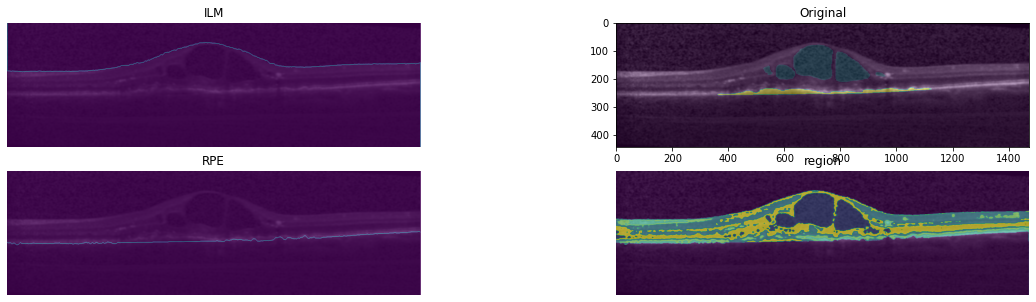

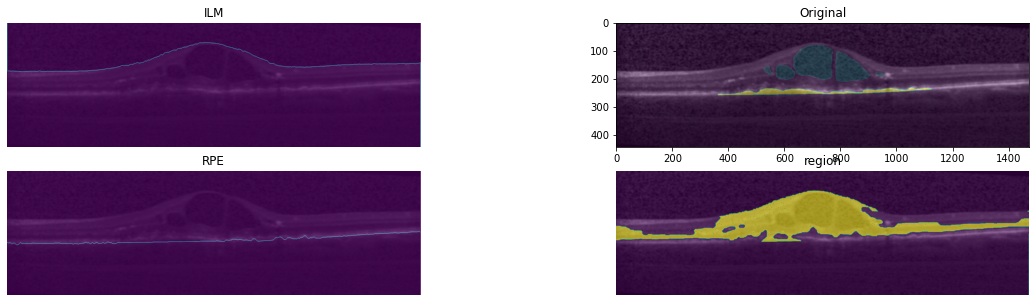

In [28]:
# Image Loading:
manufacturer = 'Spectralis'
for i in range(20,25,5):
    print(i)
    slice_ = i

    itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-Spectralis/TRAIN025/oct.mhd')
    ref_itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-Spectralis/TRAIN025/reference.mhd')

    oct_scan = sitk.GetArrayFromImage(itkimage)
    ref_oct_scan = sitk.GetArrayFromImage(ref_itkimage)

    # Preprocess:
    # GUARDAR SIZE Y POSICIONES ORIGINALES PARA RECONSTRUIR TAMAÑO ORIGINAL A LA SALIDA
    im, ref = region_extractor(manufacturer, oct_scan[slice_, :, :], ref_oct_scan[slice_, :, :])
    
    spacing = itkimage.GetSpacing()
    im = skimage.transform.rescale(im, (1, spacing[0]/spacing[1]), order=2)
    ref = skimage.transform.rescale(ref, (1, spacing[0]/spacing[1]), order=0)
    
    if manufacturer=='Spectralis':
        cv2.normalize(im, im, 0, 255, cv2.NORM_MINMAX)
        im = im.astype('uint8')
        im = cv2.bilateralFilter(src=im, d=10, sigmaColor=200, sigmaSpace=2)

    # Get the NS tranform
    T, I = ns_mapper_using_complements(im, 10)
    T = skimage.util.invert(T)

    # Get ILM line
    _, _, _, ilm_image = get_ilm_line_paper(im, T, I)
    
    # Get RPE line and flatten()
    _, _, _, _, rpe_image, indices = get_rpe_line(im, T, I, ilm_image)
    new_rpe_image, _, _, _, _, _, _ = rpe_flattening(rpe_image, w=150, tr = 40, n=1, k=101)
    # Probar filtrado más grande y ventana de pixeles ilm más grande
    
    retina_mask = get_retina_mask(ilm_image.copy(), new_rpe_image.copy())
    
    # Neutrosophic transform
    im_NS = Neutrsophic_Image(im)
    _, im_am_be, betaI = alpha_mean_beta_enh(im_NS)
    
    # Kmeans clustering
    result_clust = clustering(im_am_be, retina_mask, 5)
    
    # Sample the seeds
    fluid_seeds, bkg_seeds = select_seeds(im_am_be, result_clust, n_clust=5, FN=500, TN=700)
    
    plots(im, ref, ilm_image, new_rpe_image, result_clust)
    
    # Obtain the regional terms for object and background
    reg_term_obj, R1p_obj, R1p_bkg = regional_term(im_am_be, fluid_seeds, bkg_seeds, I, region='object')
    reg_term_bkg, R1p_obj, R1p_bkg = regional_term(im_am_be, fluid_seeds, bkg_seeds, I, region='bkg')
    
    
    # Obtain the full weigthed graph
    graph_, nodes = get_graph_flow(
        im_am_be, retina_mask, fluid_seeds, bkg_seeds, reg_term_obj,
        reg_term_bkg,  lamda1 = 1e8, lamda2 = 1e8
    )
    
    # USING SCIPY
#     start = time.time()
#     [m,n] = graph_.shape
#     flow = scipy.sparse.csgraph.maximum_flow(graph_, 0, m-1)
#     matching = flow.residual[1:m-1, m-1:2*m-1]
#     print(matching.toarray())
#     print(np.count_nonzero(matching.toarray()))
#     print(time.time() - start)
#     a = np.zeros(retina_mask.shape)
#     pos = np.where(retina_mask[:,:])
#     a[pos[0],pos[1]] = matching.toarray()[:,0]
#     matching.reshape(im_am_be.shape)
    
    # Get mincut
#     G = nx.from_scipy_sparse_matrix(graph_, create_using=nx.Graph, edge_attribute='capacity')
#     cut_value, partition = nx.max_flow_min_cost(G, 0, graph_.shape[0]-1)
    start = time.time()
    G = nx.from_scipy_sparse_matrix(graph_, create_using=nx.Graph, edge_attribute='capacity')
    cut_value, partition = nx.minimum_cut(G, 0, graph_.shape[0]-1)
    reachable, non_reachable = partition
    
    segmentation = np.zeros(im_am_be.shape[0] * im_am_be.shape[1])
    obj_nodes = np.array(list(reachable)[1:])-1
    bkg_nodes = np.array(list(reachable)[:-1])-1
    segmentation[nodes[obj_nodes]] = 1
    segmentation = np.reshape(segmentation, (im_am_be.shape))
    
    plots(im, ref, ilm_image, new_rpe_image, segmentation)

20


/home/joaquin/anaconda3/envs/improject/lib/python3.7/site-packages/skimage/transform/_warps.py:220: UserWarning: Bi-quadratic interpolation behavior has changed due to a bug in the implementation of scikit-image. The new version now serves as a wrapper around SciPy's interpolation functions, which itself is not verified to be a correct implementation. Until skimage's implementation is fixed, we recommend to use bi-linear or bi-cubic interpolation instead.
  preserve_range=preserve_range)


[1 5 2 4 3]


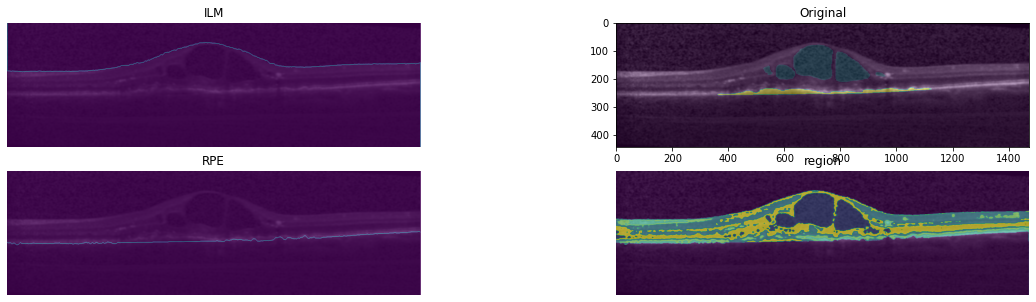

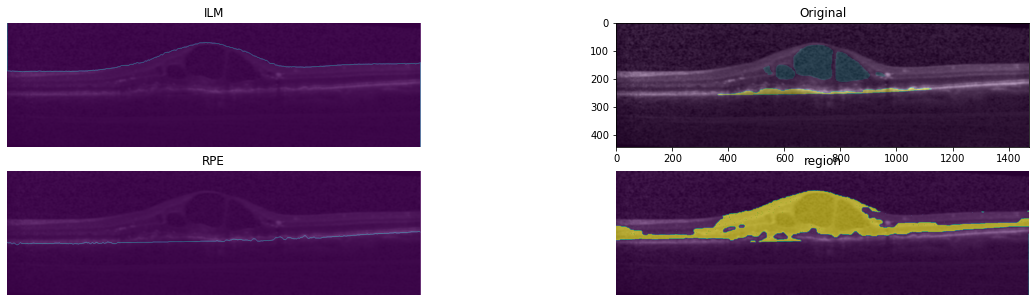

In [31]:
# Image Loading:
manufacturer = 'Spectralis'
for i in range(20,25,5):
    print(i)
    slice_ = i

    itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-Spectralis/TRAIN025/oct.mhd')
    ref_itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-Spectralis/TRAIN025/reference.mhd')

    oct_scan = sitk.GetArrayFromImage(itkimage)
    ref_oct_scan = sitk.GetArrayFromImage(ref_itkimage)

    # Preprocess:
    # GUARDAR SIZE Y POSICIONES ORIGINALES PARA RECONSTRUIR TAMAÑO ORIGINAL A LA SALIDA
    im, ref = region_extractor(manufacturer, oct_scan[slice_, :, :], ref_oct_scan[slice_, :, :])
    
    spacing = itkimage.GetSpacing()
    im = skimage.transform.rescale(im, (1, spacing[0]/spacing[1]), order=2)
    ref = skimage.transform.rescale(ref, (1, spacing[0]/spacing[1]), order=0)
    
    if manufacturer=='Spectralis':
        cv2.normalize(im, im, 0, 255, cv2.NORM_MINMAX)
        im = im.astype('uint8')
        im = cv2.bilateralFilter(src=im, d=10, sigmaColor=200, sigmaSpace=2)

    # Get the NS tranform
    T, I = ns_mapper_using_complements(im, 10)
    T = skimage.util.invert(T)

    # Get ILM line
    _, _, _, ilm_image = get_ilm_line_paper(im, T, I)
    
    # Get RPE line and flatten()
    _, _, _, _, rpe_image, indices = get_rpe_line(im, T, I, ilm_image)
    new_rpe_image, _, _, _, _, _, _ = rpe_flattening(rpe_image, w=150, tr = 40, n=1, k=101)
    # Probar filtrado más grande y ventana de pixeles ilm más grande
    
    retina_mask = get_retina_mask(ilm_image.copy(), new_rpe_image.copy())
    
    # Neutrosophic transform
    im_NS = Neutrsophic_Image(im)
    _, im_am_be, betaI = alpha_mean_beta_enh(im_NS)
    
    # Kmeans clustering
    result_clust = clustering(im_am_be, retina_mask, 5)
    
    # Sample the seeds
    fluid_seeds, bkg_seeds = select_seeds(im_am_be, result_clust, n_clust=5, FN=500, TN=700)
    
    plots(im, ref, ilm_image, new_rpe_image, result_clust)
    
    # Obtain the regional terms for object and background
    reg_term_obj, R1p_obj, R1p_bkg = regional_term(im_am_be, fluid_seeds, bkg_seeds, I, region='object')
    reg_term_bkg, R1p_obj, R1p_bkg = regional_term(im_am_be, fluid_seeds, bkg_seeds, I, region='bkg')
    
    
    # Obtain the full weigthed graph
    graph_, nodes = get_graph_flow(
        im_am_be, retina_mask, fluid_seeds, bkg_seeds, reg_term_obj,
        reg_term_bkg,  lamda1 = 1e8, lamda2 = 1e8
    )
    
    # USING SCIPY
#     start = time.time()
#     [m,n] = graph_.shape
#     flow = scipy.sparse.csgraph.maximum_flow(graph_, 0, m-1)
#     matching = flow.residual[1:m-1, m-1:2*m-1]
#     print(matching.toarray())
#     print(np.count_nonzero(matching.toarray()))
#     print(time.time() - start)
#     a = np.zeros(retina_mask.shape)
#     pos = np.where(retina_mask[:,:])
#     a[pos[0],pos[1]] = matching.toarray()[:,0]
#     matching.reshape(im_am_be.shape)
    
    # Get mincut
#     G = nx.from_scipy_sparse_matrix(graph_, create_using=nx.Graph, edge_attribute='capacity')
#     cut_value, partition = nx.max_flow_min_cost(G, 0, graph_.shape[0]-1)
    start = time.time()
    G = nx.from_scipy_sparse_matrix(graph_, create_using=nx.Graph, edge_attribute='capacity')
    cut_value, partition = nx.minimum_cut(G, 0, graph_.shape[0]-1)
    reachable, non_reachable = partition
    
    segmentation = np.zeros(im_am_be.shape[0] * im_am_be.shape[1])
    obj_nodes = np.array(list(reachable)[1:])-1
    bkg_nodes = np.array(list(reachable)[:-1])-1
    segmentation[nodes[obj_nodes]] = 1
    segmentation = np.reshape(segmentation, (im_am_be.shape))
    
    plots(im, ref, ilm_image, new_rpe_image, segmentation)

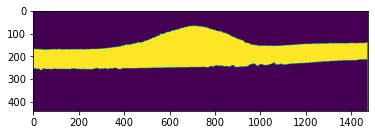

In [165]:
a[pos[0],pos[1]] = np.array(np.sum(graph_[0,:].astype(int), axis=1)[:,0])[:,0]
plt.imshow(np.where(a>1.3e13,1,0))

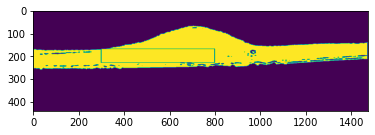

In [261]:
a = np.zeros(retina_mask.shape)
pos = np.where(retina_mask[:,1:-1])
a[pos[0],pos[1]] = np.array(np.sum(graph_[1:-1,1:-1].astype(int), axis=1)[:,0])[:,0]
plt.imshow(np.where(a>3.25e8,1,0))

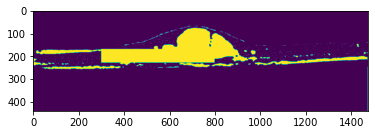

In [209]:
a = np.zeros(retina_mask.shape)
pos = np.where(retina_mask[:,1:-1])
a[pos[0],pos[1]] = np.array(graph_[0,1:-1].toarray())
plt.imshow(np.where(a>3.5e12,1,0))

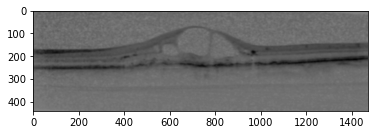

In [42]:
plt.imshow(im_am_be, cmap='gray')

### BACKUP

In [453]:
a = np.zeros(retina_mask.shape)
pos = np.where(retina_mask[:,1:-1])
a[pos[0],pos[1]] = np.array(np.sum(graph_[1:-1,1:-1].astype(int), axis=1)[:,0])[:,0]
plt.imshow(a)

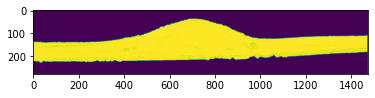

In [ ]:

# NEUTROSOFIC MAPPER All slices at the same time:
# g = oct_scan.copy()

# # Step 2
# g_comp = 255 - oct_image
# T = np.zeros(g_comp.shape)
# g_comp_min = np.min(np.min(g_comp, axis=2), axis=1)
# g_comp_max = np.max(np.max(g_comp,axis=2), axis=1)
# for i in range(len(g_comp_min)):
#     T[i,:,:] = 1 - (g_comp[i,:,:] - g_comp_min[i])/(g_comp_max[i] - g_comp_min[i])

# # Step 3
# kernel = gker((3,9),1)

# # Steps 4,5, 6
# I = np.zeros((T.shape))
# Ind = np.zeros((T.shape))
# for i in range(T.shape[0]):
#     FI = np.zeros((10, T.shape[1], T.shape[2]))
#     for j in range(0,10):                                             # Step 5
#         rotated_kernel = ndimage.rotate(kernel, 18*j, reshape=True)   # Step 4
#         FI[j,:,:] = cv2.filter2D(T[i,:,:], -1, rotated_kernel)
#     T_FI_abs_dif = np.abs(np.repeat(np.expand_dims(T[i,:,:],0),10,0) - FI)
#     I[j,:,:] = np.min(T_FI_abs_dif, axis=0) # Step 6
#     Ind[j,:,:] = np.max(T_FI_abs_dif, axis=0)

# # Step 7
# T[T >= 0.7] = Ind[T >= 0.7]
# scipy.stats.entropy(I.reshape((I.shape[0], I.shape[1]*I.shape[2])), axis=1)